## States

In [5]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: list

class SumState(TypedDict):
    a: float
    b: float

class MulState(TypedDict):
    a: float
    b: float

class DivState(TypedDict):
    a: float
    b: float

class OperState(TypedDict):
    operation: str

## Nodes

In [6]:
def add(SumState):
    print("---Add---")
    return {"add result": SumState['a'] +SumState['b']}

def mul(MulState):
    print("---Multiplication---")
    return {"Multiplication result": MulState['a'] * MulState['b']}

def div(DivState):
    print("---Division---")
    return {"Division result": DivState['a'] / DivState['b']}

## Edges

In [7]:
from typing import Literal

def decide_operation(OperState) -> Literal["add", "mul", "div"]:

    user_input = OperState['operation']

    if user_input == '+':
        return "add"
    elif user_input == '*':
        return "mul"
    elif user_input == '/':
        return "div"

## Graph Construction

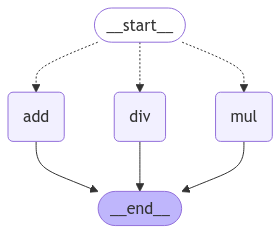

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("add", add)
builder.add_node("mul", mul)
builder.add_node("div", div)

# Logic
builder.add_conditional_edges(START, decide_operation)
builder.add_edge("add", END)
builder.add_edge("mul", END)
builder.add_edge("div", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))



In [9]:
graph.invoke({"OperState": '+'})

InvalidUpdateError: Expected node __start__ to update at least one of ['graph_state'], got {'OperState': '+'}

In [10]:
graph.invoke({"graph_state": '+'})

KeyError: 'operation'

In [7]:
from langchain_ollama import ChatOllama


def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first float
        b: second float
    """
    return a * b

def add(a: float, b: float) -> float:
    """Add a and b.
    
    Args:
        a: first float number to add 
        b: second float number to add
    """
    return a + b

def divide(a: float, b: float) -> float:
    """Divide a and b.
    
    Args:
        a: first float number to divide
        b: second float number to divide
    """
    return a / b

llm = ChatOllama(model="llama3.1", temperature=0)

llm_with_tools = llm.bind_tools([add, multiply, divide])




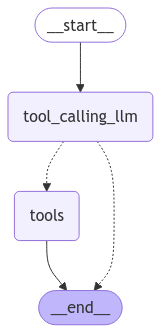

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, divide]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Could you perfom the following operation?: [(53x3 + 2)/2] + 35")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Could you perfom the following operation?: [(53x3 + 2)/2] + 35
================================== Ai Message ==================================
Tool Calls:
  divide (568141ff-45b4-4670-b0cc-a33d27eb7b7b)
 Call ID: 568141ff-45b4-4670-b0cc-a33d27eb7b7b
  Args:
    a: 161
    b: 2
  add (8dea6ff0-5b6c-41b9-88be-013c64c06f0e)
 Call ID: 8dea6ff0-5b6c-41b9-88be-013c64c06f0e
  Args:
    a: 35
    b: 80
================================= Tool Message =================================
Name: divide

80.5
================================= Tool Message =================================
Name: add

115.0
